<a href="https://colab.research.google.com/github/RD191295/Stock-Market-Prediction-/blob/main/Stock_Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data as pdr

In [10]:
# let us get data from yahoo finance
yf.pdr_override()
stock_data = pdr.get_data_yahoo("IEX.NS", start="2010-01-01", end="2022-09-23")

[*********************100%***********************]  1 of 1 completed


In [11]:
# let check data
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-23,50.000000,55.333332,50.000000,54.305000,51.381550,100373940
2017-10-24,53.833332,54.501667,53.174999,53.446667,50.569427,6492840
2017-10-25,53.333332,53.366665,51.521667,52.101665,49.296829,4222440
2017-10-26,51.748333,53.000000,51.036667,52.088333,49.284214,2614500
2017-10-27,52.000000,52.493332,51.703335,52.169998,49.361485,934440


In [12]:
stock_data = stock_data.reset_index(level=0)
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-23,50.000000,55.333332,50.000000,54.305000,51.381550,100373940
1,2017-10-24,53.833332,54.501667,53.174999,53.446667,50.569427,6492840
2,2017-10-25,53.333332,53.366665,51.521667,52.101665,49.296829,4222440
3,2017-10-26,51.748333,53.000000,51.036667,52.088333,49.284214,2614500
4,2017-10-27,52.000000,52.493332,51.703335,52.169998,49.361485,934440


In [13]:
# Let us check null values
stock_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Text(0, 0.5, 'Prices in INR')

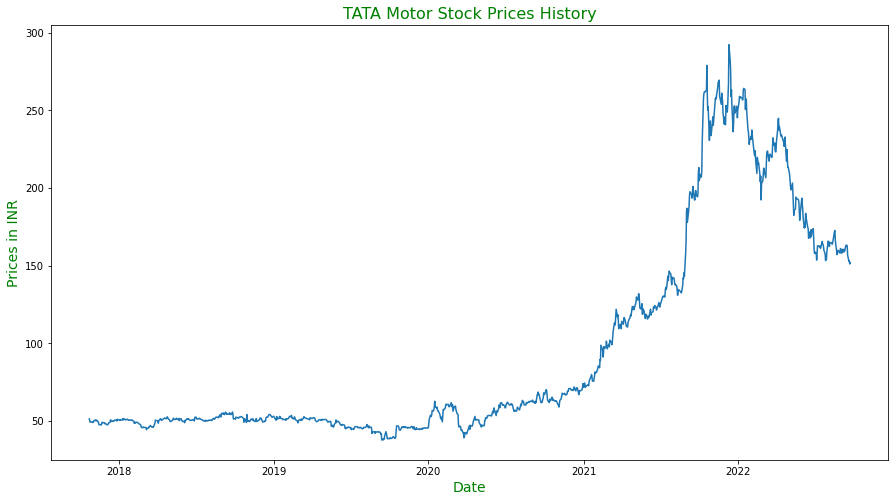

In [14]:
plt.figure(figsize=(15, 8))
plt.title('IEX Stock Prices History', fontsize = 16,color='green')
plt.plot(stock_data['Date'],stock_data['Adj Close'])
plt.xlabel('Date',fontsize =14, color = "green")
plt.ylabel('Prices in INR', fontsize = 14, color = "green")

In [15]:
#Set Target Variable
output_var = pd.DataFrame(stock_data["Adj Close"])

# Select features
features = ["Open",	"High",	"Low",	"Close"]

In [16]:
# Scaling
scaler = MinMaxScaler()
stock_data_scaled = scaler.fit_transform(stock_data[features])

In [17]:
#Splitting to Training set and Test set
from sklearn.model_selection import TimeSeriesSplit
timesplit = TimeSeriesSplit(n_splits = 10)

for train_index, test_index in timesplit.split(stock_data_scaled):
  X_train, X_test = stock_data_scaled[:len(train_index)], stock_data_scaled[len(train_index): len(train_index) + len(test_index)]
  Y_train, Y_test = output_var[:len(train_index)].values.ravel(),  output_var[len(train_index): len(train_index) + len(test_index)].values.ravel()

In [18]:
# Let check shape of X_train, X_test, Y_train, Y_test
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("Y_train shape:",Y_train.shape)
print("Y_test shape:",Y_test.shape)


X_train shape: (1107, 4)
X_test shape: (110, 4)
Y_train shape: (1107,)
Y_test shape: (110,)


In [19]:
# Let us reshape data 
train_data = np.array(X_train)
test_data = np.array(X_test)

# reshape it for model 
X_train = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1])) 
X_test = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1])) 

In [20]:
# Let check shape of X_train, X_test, Y_train, Y_test
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("Y_train shape:",Y_train.shape)
print("Y_test shape:",Y_test.shape)

X_train shape: (1107, 1, 4)
X_test shape: (110, 1, 4)
Y_train shape: (1107,)
Y_test shape: (110,)


In [21]:
# Model

stock_model = tf.keras.models.Sequential()

stock_model.add(tf.keras.layers.LSTM(units = 1024, input_shape = (1,train_data.shape[1]), return_sequences= True))
stock_model.add(tf.keras.layers.LSTM(units = 512, return_sequences= True))
stock_model.add(tf.keras.layers.LSTM(units = 256, return_sequences= True))
stock_model.add(tf.keras.layers.LSTM(units = 128))
stock_model.add(tf.keras.layers.Dense(units = 1))

stock_model.compile(optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.1),
                    loss = "mean_squared_error")

In [22]:
# Let us check stock_model summary
stock_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 1024)           4214784   
                                                                 
 lstm_1 (LSTM)               (None, 1, 512)            3147776   
                                                                 
 lstm_2 (LSTM)               (None, 1, 256)            787456    
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 8,347,265
Trainable params: 8,347,265
Non-trainable params: 0
_________________________________________________________________


In [86]:
# we will train model on X_train , Y_train
stock_model.fit(X_train, Y_train, epochs = 100, batch_size = 64, verbose = 1, shuffle = False)

Epoch 1/100
18/18 [==============================] - 3s 149ms/step - loss: 86.9505
Epoch 2/100
18/18 [==============================] - 3s 148ms/step - loss: 86.7676
Epoch 3/100
18/18 [==============================] - 3s 149ms/step - loss: 86.5851
Epoch 4/100
18/18 [==============================] - 3s 147ms/step - loss: 86.4029
Epoch 5/100
18/18 [==============================] - 3s 146ms/step - loss: 86.2209
Epoch 6/100
18/18 [==============================] - 3s 149ms/step - loss: 86.0394
Epoch 7/100
18/18 [==============================] - 3s 149ms/step - loss: 85.8581
Epoch 8/100
18/18 [==============================] - 3s 148ms/step - loss: 85.6772
Epoch 9/100
18/18 [==============================] - 3s 150ms/step - loss: 85.4966
Epoch 10/100
18/18 [==============================] - 3s 147ms/step - loss: 85.3162
Epoch 11/100
18/18 [==============================] - 3s 147ms/step - loss: 85.1363
Epoch 12/100
18/18 [==============================] - 3s 148ms/step - loss: 84.9566
E

In [87]:
# let us predict output 
Y_pred = tf.squeeze(stock_model.predict(X_test))

In [88]:
Y_pred

<tf.Tensor: shape=(110,), dtype=float32, numpy=
array([223.90358, 223.66347, 223.85484, 224.37965, 223.92882, 221.0916 ,
       222.18114, 221.55016, 219.30693, 217.35191, 215.04912, 210.9587 ,
       206.3791 , 202.18411, 205.63928, 203.76231, 194.75548, 185.24814,
       188.35564, 188.0065 , 194.36816, 198.4782 , 193.20323, 197.83922,
       196.98723, 195.26707, 187.90703, 180.08736, 183.06859, 190.44673,
       195.80772, 193.57677, 189.40736, 184.82246, 174.7108 , 174.82784,
       174.2365 , 178.66977, 180.56378, 174.87984, 173.91461, 172.55132,
       168.65654, 167.09279, 166.1132 , 168.93892, 167.24873, 166.87302,
       169.53943, 172.5025 , 165.81395, 158.66786, 156.22194, 155.58517,
       155.87611, 153.46808, 153.8417 , 158.87247, 159.56067, 159.4857 ,
       159.91408, 160.054  , 158.84973, 158.8271 , 161.92801, 161.2462 ,
       161.66316, 160.35068, 158.45262, 155.88313, 152.4319 , 150.83559,
       152.10683, 154.99477, 160.02649, 163.36552, 162.57668, 160.55843,
   

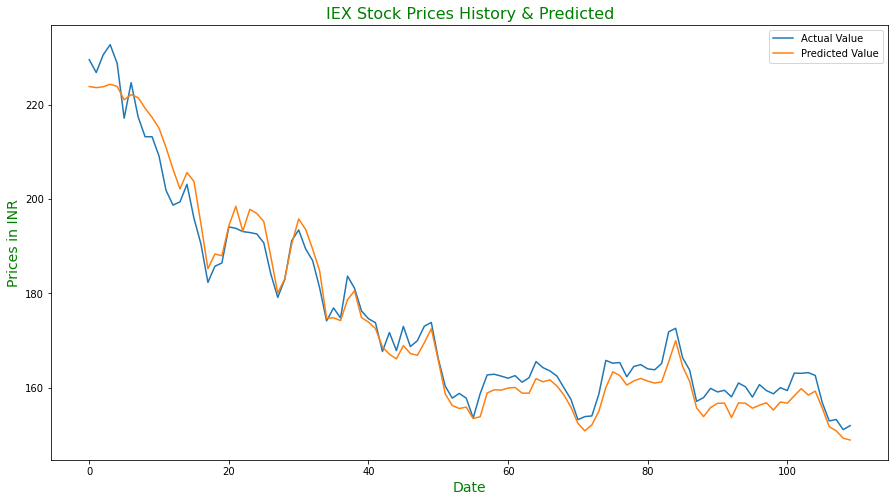

In [89]:
plt.figure(figsize=(15, 8))
plt.title('IEX Stock Prices History & Predicted', fontsize = 16,color='green')
plt.plot(Y_test, label= "Actual Value")
plt.plot(Y_pred, label = "Predicted Value")
plt.xlabel('Date',fontsize =14, color = "green")
plt.ylabel('Prices in INR', fontsize = 14, color = "green")
plt.legend()
plt.show()

In [90]:
stock_model.save('IEX_Stock_prediction.h5')